# Análisis de Clientes

Análisis visual del comportamiento de clientes, segmentación y distribución geográfica.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 6)

### Cargar dataset consolidado

In [2]:
df = pd.read_csv('../data/processed/datos_consolidados.csv')
df['fecha'] = pd.to_datetime(df['fecha'])
print(f"✓ {df.shape[0]} registros | {df['id_cliente'].nunique()} clientes | {df['ciudad'].nunique()} ciudades")

✓ 343 registros | 67 clientes | 6 ciudades


## Segmentación de Clientes (RFM)

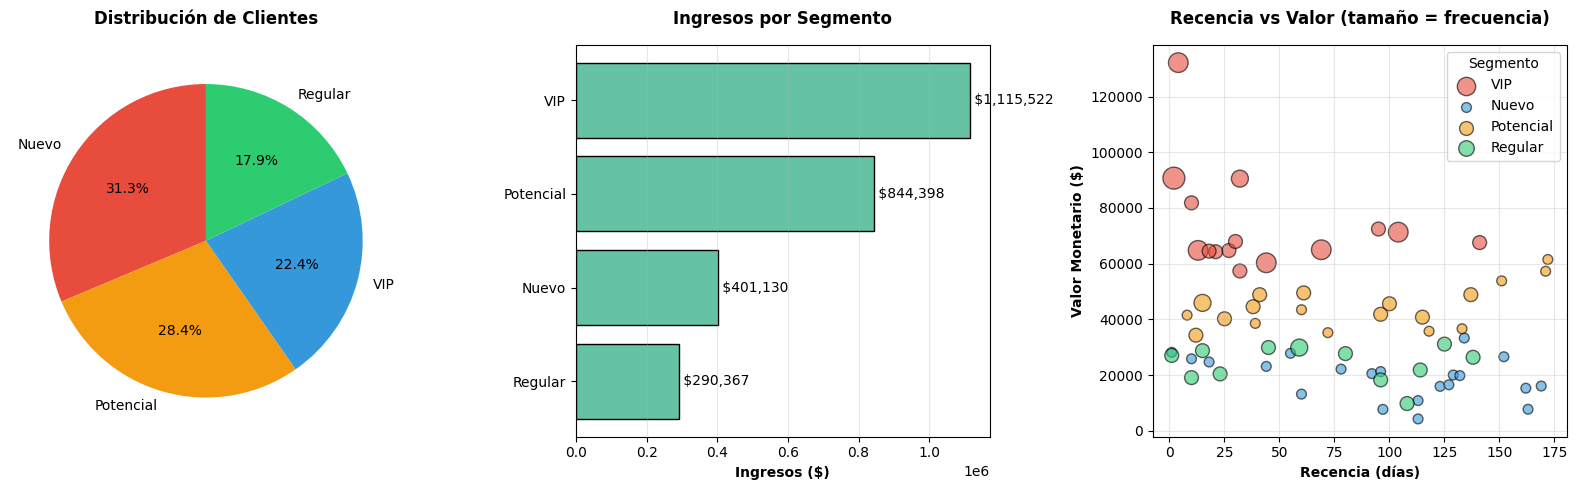


Clientes VIP: 15 (22.4%)
Ingresos VIP: $1,115,522


In [3]:
# Análisis RFM
fecha_ref = df['fecha'].max() + pd.Timedelta(days=1)

rfm = df.groupby('id_cliente').agg({
    'fecha': lambda x: (fecha_ref - x.max()).days,
    'id_venta': 'nunique',
    'importe': 'sum'
}).reset_index()
rfm.columns = ['id_cliente', 'Recency', 'Frequency', 'Monetary']

# Categorizar segmentos (sin usar qcut para evitar problemas con duplicados)
def categorizar_cliente(row):
    if row['Monetary'] >= rfm['Monetary'].quantile(0.75) and row['Frequency'] >= rfm['Frequency'].median():
        return 'VIP'
    elif row['Monetary'] >= rfm['Monetary'].median():
        return 'Potencial'
    elif row['Frequency'] == 1:
        return 'Nuevo'
    else:
        return 'Regular'

rfm['Segmento'] = rfm.apply(categorizar_cliente, axis=1)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Distribución de segmentos
segmentos = rfm['Segmento'].value_counts()
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
axes[0].pie(segmentos.values, labels=segmentos.index, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title('Distribución de Clientes', fontweight='bold', pad=15)

# Ingresos por segmento
ingresos_seg = rfm.groupby('Segmento')['Monetary'].sum().sort_values(ascending=True)
axes[1].barh(ingresos_seg.index, ingresos_seg.values, color='#66c2a5', edgecolor='black')
axes[1].set_xlabel('Ingresos ($)', fontweight='bold')
axes[1].set_title('Ingresos por Segmento', fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(ingresos_seg.values):
    axes[1].text(v, i, f' ${v:,.0f}', va='center')

# Scatter RFM
scatter_colors = {'VIP': '#e74c3c', 'Potencial': '#f39c12', 'Nuevo': '#3498db', 'Regular': '#2ecc71'}
for seg in rfm['Segmento'].unique():
    data_seg = rfm[rfm['Segmento'] == seg]
    axes[2].scatter(data_seg['Recency'], data_seg['Monetary'], s=data_seg['Frequency']*50, 
                   alpha=0.6, label=seg, color=scatter_colors[seg], edgecolors='black')
axes[2].set_xlabel('Recencia (días)', fontweight='bold')
axes[2].set_ylabel('Valor Monetario ($)', fontweight='bold')
axes[2].set_title('Recencia vs Valor (tamaño = frecuencia)', fontweight='bold', pad=15)
axes[2].legend(title='Segmento')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nClientes VIP: {(rfm['Segmento'] == 'VIP').sum()} ({(rfm['Segmento'] == 'VIP').sum()/len(rfm)*100:.1f}%)")
print(f"Ingresos VIP: ${rfm[rfm['Segmento'] == 'VIP']['Monetary'].sum():,.0f}")

## Distribución Geográfica

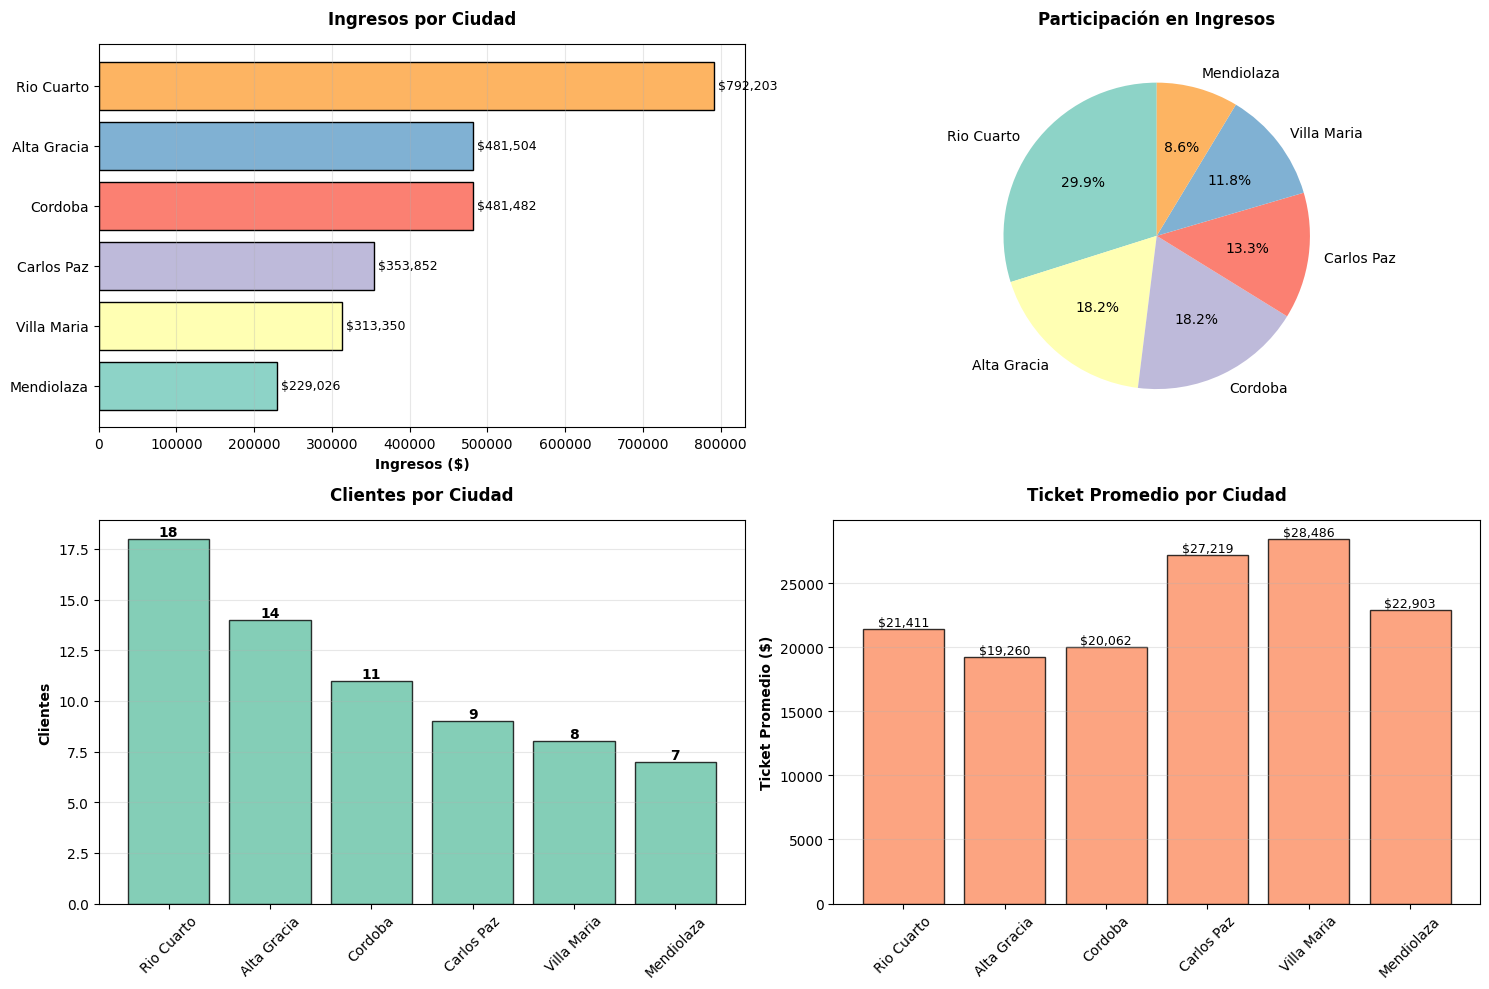

In [4]:
ciudades = df.groupby('ciudad').agg({
    'importe': 'sum',
    'id_cliente': 'nunique',
    'id_venta': 'nunique'
}).reset_index()
ciudades.columns = ['Ciudad', 'Ingresos', 'Clientes', 'Ventas']
ciudades['Ticket_Promedio'] = ciudades['Ingresos'] / ciudades['Ventas']
ciudades = ciudades.sort_values('Ingresos', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Ingresos
ciudades_sorted = ciudades.sort_values('Ingresos', ascending=True)
colors = plt.cm.Set3(range(len(ciudades)))
axes[0,0].barh(ciudades_sorted['Ciudad'], ciudades_sorted['Ingresos'], color=colors, edgecolor='black')
axes[0,0].set_xlabel('Ingresos ($)', fontweight='bold')
axes[0,0].set_title('Ingresos por Ciudad', fontweight='bold', pad=15)
axes[0,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(ciudades_sorted['Ingresos']):
    axes[0,0].text(v, i, f' ${v:,.0f}', va='center', fontsize=9)

# Participación
axes[0,1].pie(ciudades['Ingresos'], labels=ciudades['Ciudad'], autopct='%1.1f%%',
              startangle=90, colors=colors)
axes[0,1].set_title('Participación en Ingresos', fontweight='bold', pad=15)

# Clientes
axes[1,0].bar(ciudades['Ciudad'], ciudades['Clientes'], color='#66c2a5', edgecolor='black', alpha=0.8)
axes[1,0].set_ylabel('Clientes', fontweight='bold')
axes[1,0].set_title('Clientes por Ciudad', fontweight='bold', pad=15)
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)
for i, v in enumerate(ciudades['Clientes']):
    axes[1,0].text(i, v, f'{v}', ha='center', va='bottom', fontweight='bold')

# Ticket promedio
axes[1,1].bar(ciudades['Ciudad'], ciudades['Ticket_Promedio'], color='#fc8d62', edgecolor='black', alpha=0.8)
axes[1,1].set_ylabel('Ticket Promedio ($)', fontweight='bold')
axes[1,1].set_title('Ticket Promedio por Ciudad', fontweight='bold', pad=15)
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(axis='y', alpha=0.3)
for i, v in enumerate(ciudades['Ticket_Promedio']):
    axes[1,1].text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Medios de Pago

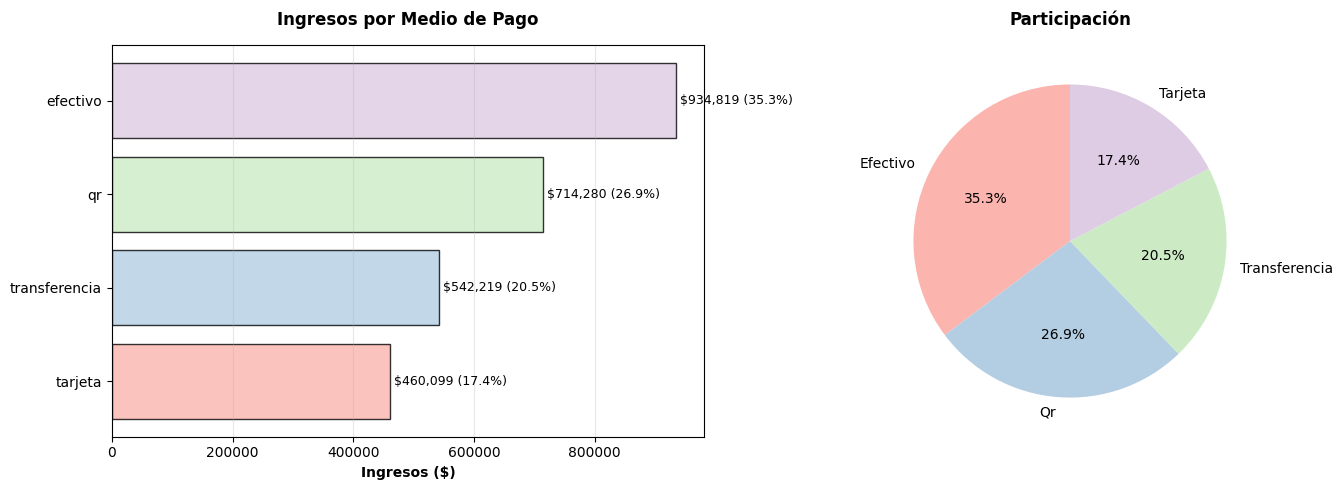

In [5]:
medios = df.groupby('medio_pago').agg({'importe': 'sum', 'id_venta': 'nunique'}).reset_index()
medios.columns = ['Medio', 'Ingresos', 'Ventas']
medios = medios.sort_values('Ingresos', ascending=False)
medios['%'] = (medios['Ingresos'] / medios['Ingresos'].sum() * 100).round(1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barras
medios_sorted = medios.sort_values('Ingresos', ascending=True)
colors = plt.cm.Pastel1(range(len(medios)))
axes[0].barh(medios_sorted['Medio'], medios_sorted['Ingresos'], color=colors, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Ingresos ($)', fontweight='bold')
axes[0].set_title('Ingresos por Medio de Pago', fontweight='bold', pad=15)
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(medios_sorted['Ingresos']):
    pct = medios_sorted['%'].iloc[i]
    axes[0].text(v, i, f' ${v:,.0f} ({pct}%)', va='center', fontsize=9)

# Pie
axes[1].pie(medios['Ingresos'], labels=medios['Medio'].str.capitalize(), autopct='%1.1f%%',
            startangle=90, colors=colors)
axes[1].set_title('Participación', fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

## Top Clientes

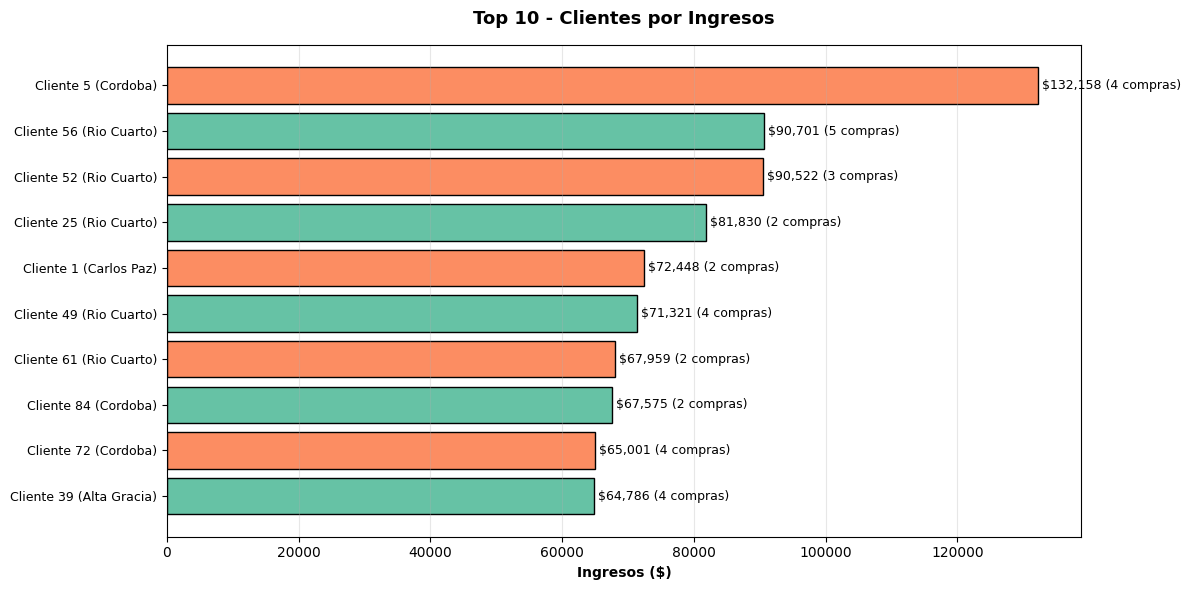


Top 10 representa: $804,301 (30.3% del total)


In [6]:
top_clientes = df.groupby('id_cliente').agg({
    'importe': 'sum',
    'id_venta': 'nunique',
    'ciudad': 'first'
}).reset_index()
top_clientes.columns = ['Cliente', 'Ingresos', 'Compras', 'Ciudad']
top_clientes = top_clientes.nlargest(10, 'Ingresos').sort_values('Ingresos', ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#66c2a5' if c % 2 == 0 else '#fc8d62' for c in range(len(top_clientes))]
ax.barh(range(len(top_clientes)), top_clientes['Ingresos'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_clientes)))
ax.set_yticklabels([f"Cliente {c} ({ciudad})" for c, ciudad in zip(top_clientes['Cliente'], top_clientes['Ciudad'])], fontsize=9)
ax.set_xlabel('Ingresos ($)', fontweight='bold')
ax.set_title('Top 10 - Clientes por Ingresos', fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

for i, (v, compras) in enumerate(zip(top_clientes['Ingresos'], top_clientes['Compras'])):
    ax.text(v, i, f' ${v:,.0f} ({compras} compras)', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nTop 10 representa: ${top_clientes['Ingresos'].sum():,.0f} ({top_clientes['Ingresos'].sum()/df['importe'].sum()*100:.1f}% del total)")